In [1]:
import torchvision
from torchvision import transforms, datasets, utils
import torch as torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import itertools
import time
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [111]:
std,mean = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) # [0,1] -> [-1,1]
def mymshow(img, std=1, mean=0, fig_size=[8,8],xlabel=None):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    fig,ax = plt.subplots()
    fig.set_size_inches(*fig_size)
    ax.imshow(img)
    ax.set_xlabel(xlabel,fontsize=28)
    plt.show()

In [4]:
def gen_block(input_channels, output_channels, kernel_size, stride, padding, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True))
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding),     
            nn.Tanh())

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            gen_block(z_dim,1024,4,1,0),
            gen_block(1024,512,4,2,1),
            gen_block(512,256,4,2,1),
            gen_block(256,128,4,2,1),
            gen_block(128,3,4,2,1,final_layer=True))
    
    def forward(self, noise):
        return self.layers(noise)

In [5]:
generator = Generator(100).to(device)
generator.load_state_dict(torch.load('generator_wgan_celeba.pt',map_location=torch.device(device)))
generator.eval();

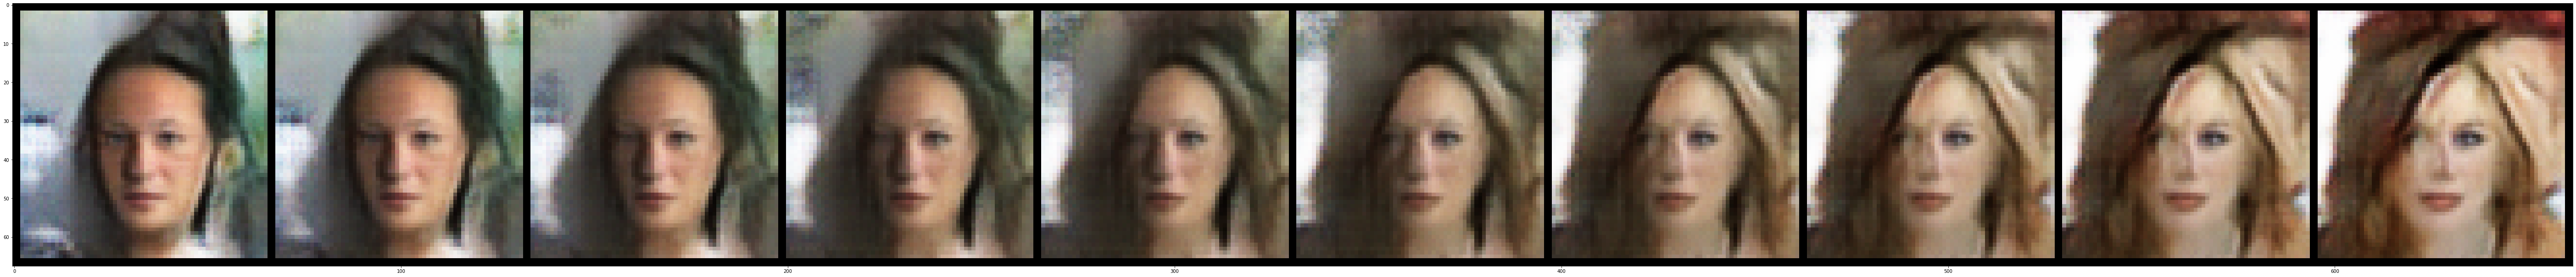

In [6]:
# Interpolation
z1 = torch.randn(1, 100, 1, 1, device=device)
z2 = torch.randn(1, 100, 1, 1, device=device)

fakes = []
for i in torch.linspace(0,1,10):
    with torch.no_grad():
        fake = generator(z1*i+z2*(1-i))
    fakes.append(fake)

mymshow(utils.make_grid(torch.cat(fakes,0),nrow=10,normalize=True),fig_size=[100,100])

In [184]:
class NNet(nn.Module):
    def __init__(self, num_attributes):
        super(NNet, self).__init__()
        self.classifier = torchvision.models.resnet18(pretrained=False)
        self.classifier.fc = nn.Linear(self.classifier.fc.in_features, num_attributes)
    def forward(self, xb):
        yhat = self.classifier(xb)#.sigmoid()
        return yhat

In [185]:
relevant_attributes = ['Black_Hair', 'Blond_Hair', 'Eyeglasses','Smiling' ]
classifier = NNet(len(relevant_attributes)).to(device)
classifier.load_state_dict(torch.load('save_classifier.pt', map_location=torch.device(device)))
classifier.eval();

In [9]:
BLACK_HAIR_INDEX = 0
BLOND_HAIR_INDEX = 1
EYEGLASSES_INDEX = 2
SMILE_INDEX=3

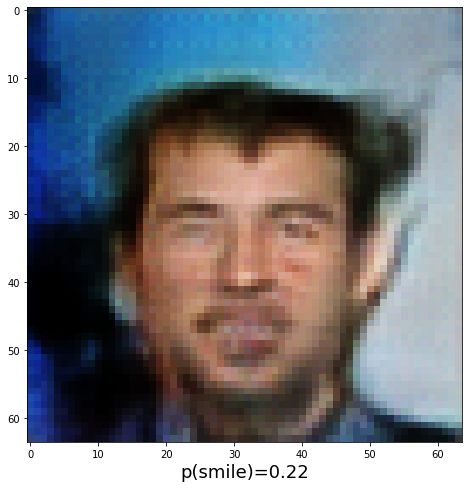

In [30]:
z = torch.randn(1, 100, 1, 1, device=device).requires_grad_()
with torch.no_grad():
    fake = generator(z)
smile_p = classifier(fake).squeeze(0)[SMILE_INDEX]
mymshow(fake.squeeze(0), std,mean,xlabel=f'p(smile)={smile_p:.2f}')

In [ ]:
z = z.detach().clone().requires_grad_()
lr=0.1
fake_history=[]
smile_p_history = []
while smile_p.sigmoid() < 0.995:
    classifier.zero_grad()
    fake = generator(z)
    smile_p = classifier(fake).squeeze(0)[SMILE_INDEX]
    smile_p.backward()
    z.data = z + (z.grad*lr)

    fake_history.append(fake.squeeze(0).detach())
    smile_p_history.append(smile_p.sigmoid())
    mymshow(fake.squeeze(0).detach(), std, mean,[4,4],xlabel=f'p(smile)={smile_p.sigmoid():.3f}')  

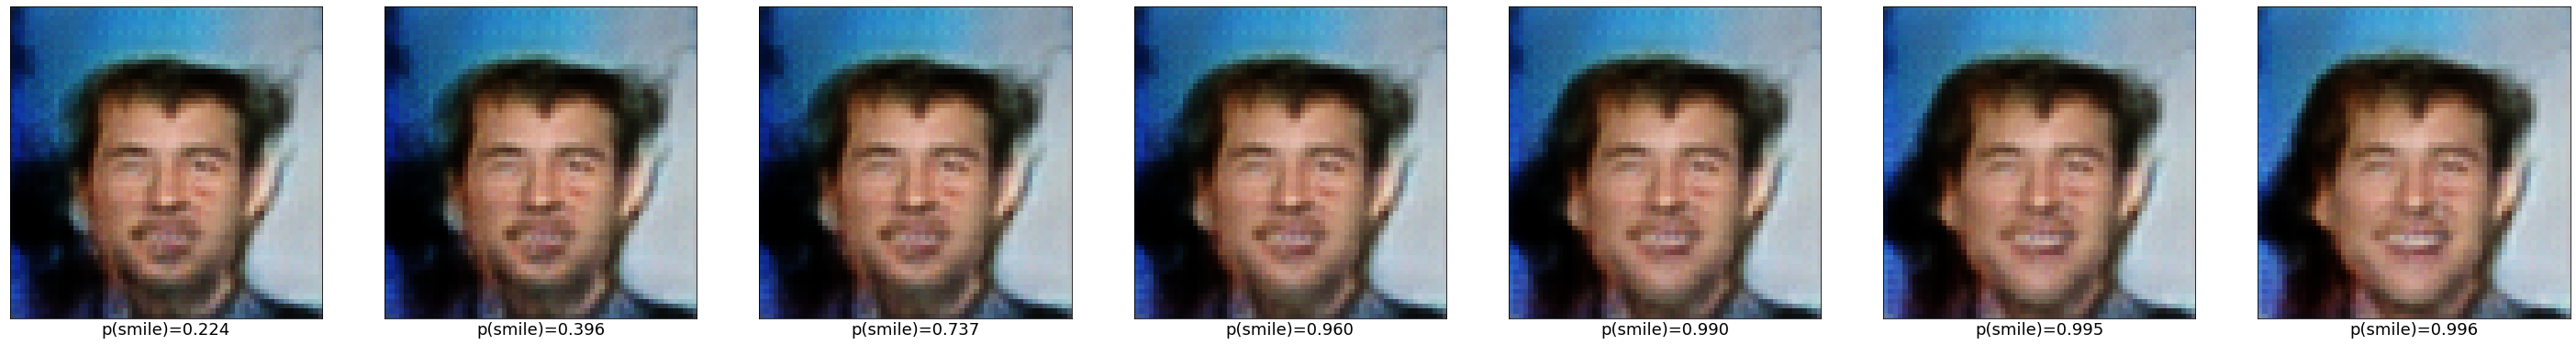

In [32]:
fake_history = fake_history[0::1]
smile_p_history = smile_p_history[0::1]
fig, axes = plt.subplots(1, len(fake_history))
for fake,p,ax in zip(fake_history,smile_p_history,axes):
    fake = fake.permute(1,2,0).cpu()
    fake = fake * torch.tensor(std) + torch.tensor(mean)
    ax.imshow(fake)
    ax.set_xlabel(f'p(smile)={p:.3f}',fontsize=18)
    ax.set_yticks([])
    ax.set_xticks([])
fig.set_size_inches(50,50)
plt.show() 

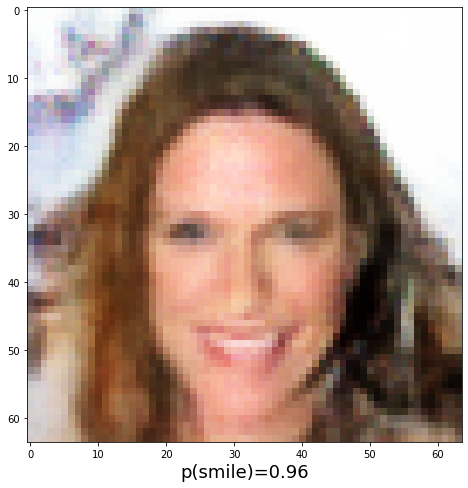

In [39]:
# remove a smile
z = torch.randn(1, 100, 1, 1, device=device).requires_grad_()
with torch.no_grad():
    fake = generator(z)
smile_p = classifier(fake).squeeze(0)[SMILE_INDEX]
mymshow(fake.squeeze(0), std,mean,xlabel=f'p(smile)={smile_p.sigmoid():.2f}')

In [ ]:
z = z.detach().clone().requires_grad_()
lr=0.1
fake_history=[]
smile_p_history = []
while smile_p.sigmoid() > 0.1:
    classifier.zero_grad()
    fake = generator(z)
    smile_p = classifier(fake).squeeze(0)[SMILE_INDEX]
    smile_p.backward()
    z.data = z - (z.grad*lr)

    fake_history.append(fake.squeeze(0).detach())
    smile_p_history.append(smile_p.sigmoid())
    mymshow(fake.squeeze(0).detach(), std, mean,[4,4],xlabel=f'p(smile)={smile_p.sigmoid():.3f}') 

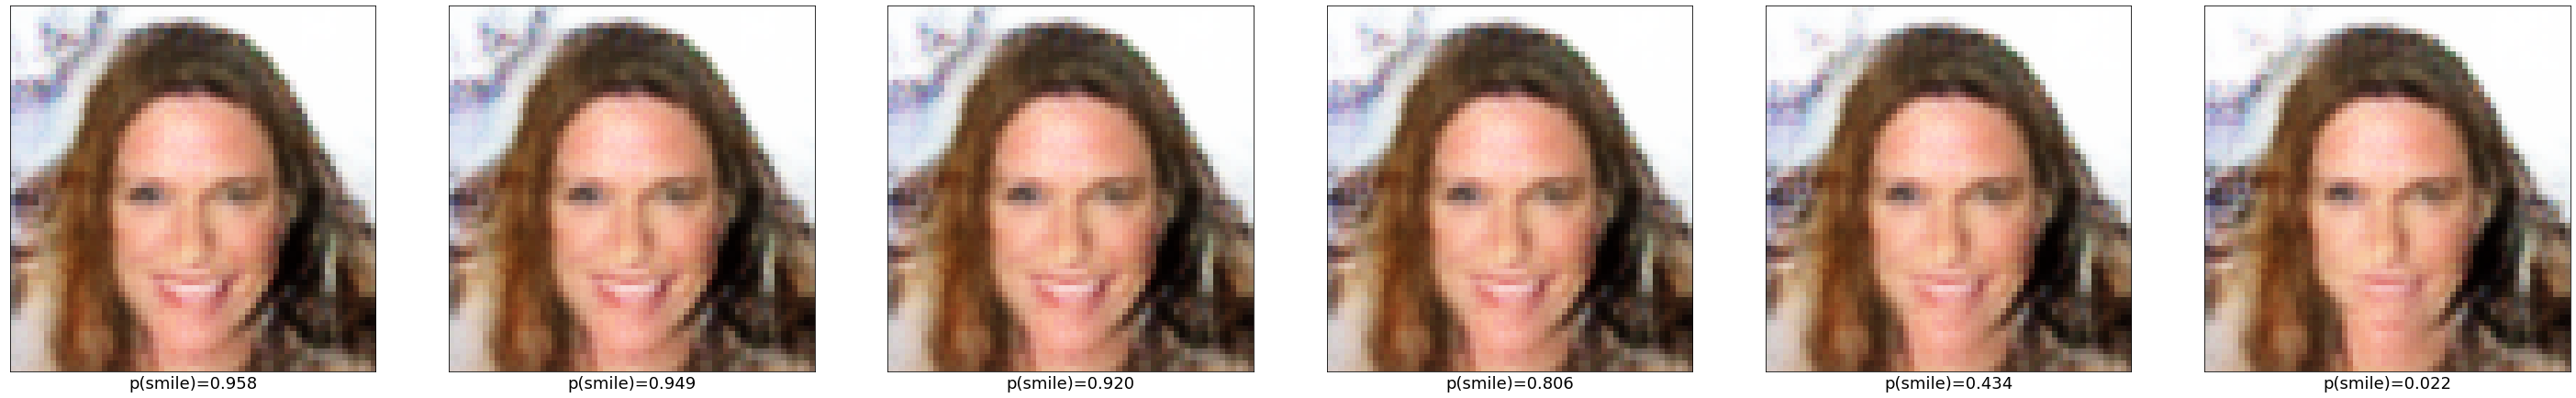

In [41]:
fake_history = fake_history[0::1]
smile_p_history = smile_p_history[0::1]
fig, axes = plt.subplots(1, len(fake_history))
for fake,p,ax in zip(fake_history,smile_p_history,axes):
    fake = fake.permute(1,2,0).cpu()
    fake = fake * torch.tensor(std) + torch.tensor(mean)
    ax.imshow(fake)
    ax.set_xlabel(f'p(smile)={p:.3f}',fontsize=18)
    ax.set_yticks([])
    ax.set_xticks([])
fig.set_size_inches(50,50)
plt.show() 

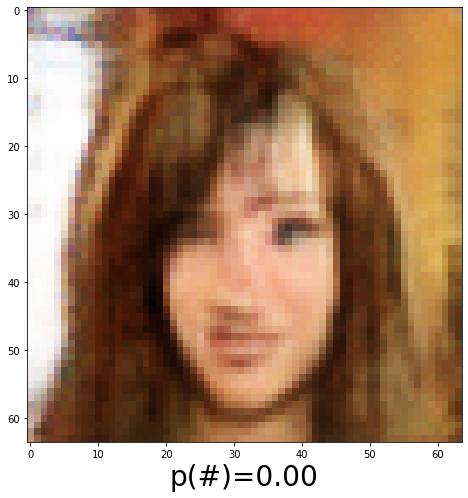

In [231]:
z0 = torch.randn(1, 100, 1, 1, device=device).requires_grad_()
with torch.no_grad():
    fake = generator(z0)
p = classifier(fake).squeeze(0)[BLACK_HAIR_INDEX]
mymshow(fake.squeeze(0), std,mean,xlabel=f'p(#)={p.sigmoid():.2f}')

In [ ]:
z = z0.detach().clone().requires_grad_()
lr=0.01
fake_history=[]
p_history = []
while p.sigmoid() < 0.99:
    classifier.zero_grad()
    fake = generator(z)
    p = classifier(fake).squeeze(0)[BLACK_HAIR_INDEX]
    p.backward()
    z.data = z + (z.grad*lr)

    fake_history.append(fake.squeeze(0).detach())
    p_history.append(p.sigmoid())
    mymshow(fake.squeeze(0).detach(), std, mean,[4,4],xlabel=f'p(#)={p.sigmoid():.3f}')  

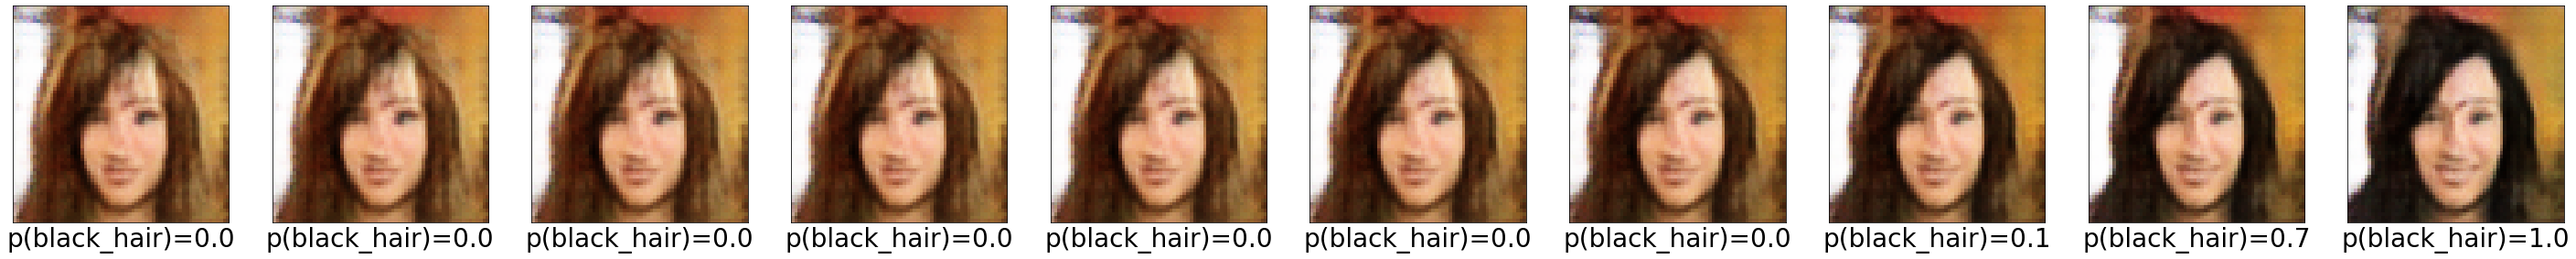

In [236]:
skip = 2
fake_history = fake_history[0::skip]
p_history = p_history[0::skip]
fig, axes = plt.subplots(1, len(fake_history))
for fake,p,ax in zip(fake_history,p_history,axes):
    fake = fake.permute(1,2,0).cpu()
    fake = fake * torch.tensor(std) + torch.tensor(mean)
    ax.imshow(fake)
    ax.set_xlabel(f'p(black_hair)={p:.1f}',fontsize=28)
    ax.set_yticks([])
    ax.set_xticks([])
fig.set_size_inches(50,50)
plt.show() 